In [87]:
import numpy as np
import matplotlib.pyplot as py

import os
import imutils

def predictive_encode_text(text):
    errors = np.zeros(len(text), dtype=np.int8)
    prediction = 0

    for i in range(len(text)):
        value = ord(text[i])
        errors[i] = value - prediction
        prediction = value

    return errors

def predictive_decode_text(encoded_errors):
    prediction = 0
    decoded_message = ['\0' for chr in encoded_errors]

    for i in range(len(encoded_errors)):
        value = encoded_errors[i] + prediction
        prediction = value
        decoded_message[i] = chr(value)

    return "".join(decoded_message)

def rgb2gray(rgb):
    return np.dot(rgb[:,:], [0.299, 0.587, 0.114])

def read_image_to_gray(file_location):
    image_read = py.imread(file_location)
    image = image_read.astype('float')
    image = rgb2gray(image)
    greyed_image = image.astype('uint8')    
    return greyed_image

# Adapted from 'Codage predictif sur image' from INF8770
def predictive_encode_image(image):
    image_row_count = len(image)
    image_column_count = len(image[0])
    # Add an additional row and column of zeroes to simplify computations
    additional_column = [[0] for row in image]
    image = np.column_stack((additional_column, image))
    additional_row = np.zeros(len(image[0]))
    image = np.row_stack((additional_row, image))

    # Prediction matrix to guess the value of a pixel from its nearest neighbors
    prediction_matrix = [[0.33, 0.33], [0.33, 0.0]]

    errors = np.zeros((image_row_count, image_column_count), dtype=np.int8)

    for y in range(1, image_row_count + 1):
        for x in range(1, image_column_count + 1):
            prediction = image[y-1][x-1] * prediction_matrix[0][0] + \
                image[y-1][x] * prediction_matrix[0][1] + \
                image[y][x-1] * prediction_matrix[1][0]
            errors[y - 1][x - 1] = prediction - image[y][x]

    return errors


def predictive_decode_image(image_errors):
    image_row_count = len(image_errors)
    image_column_count = len(image_errors[0])

    # Prediction matrix to guess the value of a pixel from its nearest neighbors
    prediction_matrix = [[0.33, 0.33], [0.33, 0.0]]

    # Add an additional row and column of zeroes to simplify computations
    image = np.zeros((image_row_count + 1, image_column_count + 1), dtype=np.int8)

    for y in range(1, image_row_count + 1):
        for x in range(1, image_column_count + 1):
            prediction = image[y-1][x-1] * prediction_matrix[0][0] + \
                image[y-1][x] * prediction_matrix[0][1] + \
                image[y][x-1] * prediction_matrix[1][0]
            image[y][x] = prediction - image_errors[y - 1][x - 1]

    return image[1:, 1:]


In [3]:
from anytree import Node, RenderTree, PreOrderIter, AsciiStyle

def huffman_encode_1D(text):
    #Liste qui sera modifié jusqu'à ce qu'elle contienne seulement la racine de l'arbre
    ArbreSymb =[[text[0], np.count_nonzero(text == text[0]), Node(text[0])]] 
    #dictionnaire obtenu à partir de l'arbre.
    dictionnaire = [[text[0], '']]
    nbsymboles = 1

    #Recherche des feuilles de l'arbre
    for i in range(1,len(text)):
        if not list(filter(lambda x: x[0] == text[i], ArbreSymb)):
            ArbreSymb += [[text[i], np.count_nonzero(text == text[i]), Node(text[i])]]
            dictionnaire += [[text[i], '']]
            nbsymboles += 1
            
    longueurOriginale = np.ceil(np.log2(nbsymboles))*len(text)    

    ArbreSymb = sorted(ArbreSymb, key=lambda x: x[1])

    while len(ArbreSymb) > 1:
        #Fusion des noeuds de poids plus faibles
        symbfusionnes = ArbreSymb[0][0] + ArbreSymb[1][0] 
        #Création d'un nouveau noeud
        noeud = Node(symbfusionnes)
        temp = [symbfusionnes, ArbreSymb[0][1] + ArbreSymb[1][1], noeud]
        #Ajustement de l'arbre pour connecter le nouveau avec ses parents 
        ArbreSymb[0][2].parent = noeud
        ArbreSymb[1][2].parent = noeud
        #Enlève les noeuds fusionnés de la liste de noeud à fusionner.
        del ArbreSymb[0:2]
        #Ajout du nouveau noeud à la liste et tri.
        ArbreSymb += [temp]

    ArbreSymb = sorted(ArbreSymb, key=lambda x: x[1])  

    while len(ArbreSymb) > 1:
        #Fusion des noeuds de poids plus faibles
        symbfusionnes = ArbreSymb[0][0] + ArbreSymb[1][0] 
        #Création d'un nouveau noeud
        noeud = Node(symbfusionnes)
        temp = [symbfusionnes, ArbreSymb[0][1] + ArbreSymb[1][1], noeud]
        #Ajustement de l'arbre pour connecter le nouveau avec ses parents 
        ArbreSymb[0][2].parent = noeud
        ArbreSymb[1][2].parent = noeud
        #Enlève les noeuds fusionnés de la liste de noeud à fusionner.
        del ArbreSymb[0:2]
        #Ajout du nouveau noeud à la liste et tri.
        ArbreSymb += [temp]
        
        ArbreSymb = sorted(ArbreSymb, key=lambda x: x[1])

    ArbreCodes = Node('')
    noeud = ArbreCodes
    #print([node.name for node in PreOrderIter(ArbreSymb[0][2])])
    parcoursprefix = [node for node in PreOrderIter(ArbreSymb[0][2])]
    parcoursprefix = parcoursprefix[1:len(parcoursprefix)] #ignore la racine

    Prevdepth = 0 #pour suivre les mouvements en profondeur dans l'arbre
    for node in parcoursprefix:  #Liste des noeuds 
        if Prevdepth < node.depth: #On va plus profond dans l'arbre, on met un 0
            temp = Node(noeud.name + '0')
            noeud.children = [temp]
            if node.children: #On avance le "pointeur" noeud si le noeud ajouté a des enfants.
                noeud = temp
        elif Prevdepth == node.depth: #Même profondeur, autre feuille, on met un 1
            temp = Node(noeud.name + '1')
            noeud.children = [noeud.children[0], temp]  #Ajoute le deuxième enfant
            if node.children: #On avance le "pointeur" noeud si le noeud ajouté a des enfants.
                noeud = temp
        else:
            for i in range(Prevdepth-node.depth): #On prend une autre branche, donc on met un 1
                noeud = noeud.parent #On remontre dans l'arbre pour prendre la prochaine branche non explorée.
            temp = Node(noeud.name + '1')
            noeud.children = [noeud.children[0], temp]
            if node.children:
                noeud = temp
            
        Prevdepth = node.depth    

    ArbreSymbList = [node for node in PreOrderIter(ArbreSymb[0][2])]
    ArbreCodeList = [node for node in PreOrderIter(ArbreCodes)]

    for i in range(len(ArbreSymbList)):
        if ArbreSymbList[i].is_leaf: #Génère des codes pour les feuilles seulement
            temp = list(filter(lambda x: x[0] == ArbreSymbList[i].name, dictionnaire))
            if temp:
                indice = dictionnaire.index(temp[0])
                dictionnaire[indice][1] = ArbreCodeList[i].name

    textCode = []
    longueur = 0 
    for i in range(len(text)):
        substitution = list(filter(lambda x: x[0] == text[i], dictionnaire))
        textCode += [substitution[0][1]]
        longueur += len(substitution[0][1]) 

    decode_dictionary = dict((v,k) for k,v in dictionnaire)
    return textCode, decode_dictionary

def huffman_decode_1D(text, dictionnary):
    return [dictionnary[c] for c in text]

def huffman_encode_2D(image):
    return huffman_encode_1D(np.array(image).flatten())

def huffman_decode_2D(image, dictionnary, x, y):
    return np.array(huffman_decode_1D(image, dictionnary)).reshape((x, y))

In [4]:
message = "ASDASDFMASDMASDASDASDASDASDMASDMKASDKASD"
print(message)

ASDASDFMASDMASDASDASDASDASDMASDMKASDKASD


In [5]:
code, dictionnary = huffman_encode_1D(message)
print(code)

['100', '101', '110', '100', '101', '110', '111', '00', '100', '101', '110', '00', '100', '101', '110', '100', '101', '110', '100', '101', '110', '100', '101', '110', '100', '101', '110', '00', '100', '101', '110', '00', '01', '100', '101', '110', '01', '100', '101', '110']


In [6]:
decoded_message = huffman_decode_1D(code, dictionnary)
print("".join(decoded_message))

ASDASDFMASDMASDASDASDASDASDMASDMKASDKASD


In [7]:
coded = predictive_encode_text(message)
print(coded)

[ 65  18 -15  -3  18 -15   2   7 -12  18 -15   9 -12  18 -15  -3  18 -15
  -3  18 -15  -3  18 -15  -3  18 -15   9 -12  18 -15   9  -2 -10  18 -15
   7 -10  18 -15]


In [8]:
decoded = predictive_decode_text(coded)
print(decoded)

ASDASDFMASDMASDASDASDASDASDMASDMKASDKASD


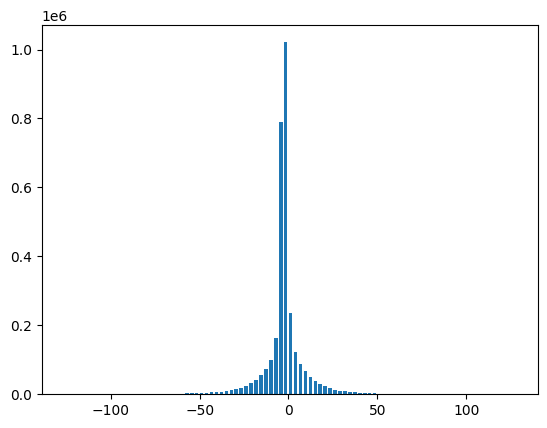

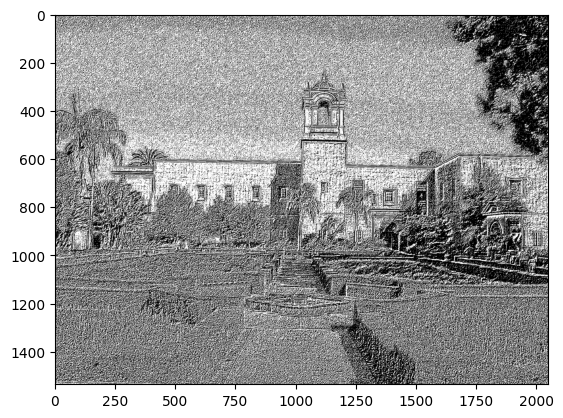

In [9]:
image = read_image_to_gray('jpeg420exif.jpg')

image_errors = predictive_encode_image(image)
image_decoded = predictive_decode_image(image_errors)

hist, intervalles = np.histogram(image_errors, bins=100)
py.bar(intervalles[:-1], hist, width = 2)
py.xlim(min(intervalles)-1, max(intervalles))
py.show()

py.imshow(image_errors.astype('uint8'), cmap = py.get_cmap('gray'))
py.show()  

# Expérience

In [92]:
def flatten_2D(list):
    return [item for sublist in list for item in sublist]

def flatten_3D(list):
    return flatten_2D(flatten_2D(list))

def test_huffman_text(text):
    coded_text, _ = huffman_encode_1D(text)
    coded_text_joined = "".join(coded_text)
    compression_percentage = (float(len(coded_text_joined)) / float((len(text)*8))) * 100

    return compression_percentage

def test_huffman_image(image_list):
    coded_image_list = []
    dictionnary_list = []
    for image in image_list:
        res = huffman_encode_2D(image)
        coded_image_list.append(res[0])
        dictionnary_list.append(res[1])

    coded_image_list_joined = "".join(map(str, flatten_3D(coded_image_list)))
    image_list_joined = flatten_3D(image_list)

    compression_percentage = (len(coded_image_list_joined) / (len(image_list_joined) * 8)) * 100

    return compression_percentage

def test_huffman_predictive_text(text):
    coded_text, _ = huffman_encode_1D(predictive_encode_text(text))
    coded_text_joined = "".join(coded_text)
    compression_percentage = (float(len(coded_text_joined)) / float((len(text)*8))) * 100

    return compression_percentage

def test_huffman_predictive_image(image_list):
    return test_huffman_image([predictive_encode_image(image) for image in image_list])

## Manipulations

In [104]:
text = open("alice29.txt", "r").read()
boat_images = [imutils.resize(read_image_to_gray(entry.path), width=100) for entry in os.scandir("boat")]
truck_images = [imutils.resize(read_image_to_gray(entry.path), width=100) for entry in os.scandir("truck")]
forest_images = [imutils.resize(read_image_to_gray(entry.path), width=100) for entry in os.scandir("forest")]

In [126]:
# Text
res_huffman_text = test_huffman_text(text)
res_huffman_predictive_text = test_huffman_predictive_text(text)

# Images
res_huffman_boats = test_huffman_image(boat_images)
res_huffman_predictive_boats = test_huffman_predictive_image(boat_images)
res_huffman_forest = test_huffman_image(forest_images)
res_huffman_predictive_forest = test_huffman_predictive_image(forest_images)


# Images of varying size
scales = range(1, 9, 1)
boat_images = [imutils.resize(read_image_to_gray(entry.path), width=200) for entry in os.scandir("boat")]
boat_images_resized = [[imutils.resize(image, width=int(scale/8*len(image[0]))) for image in boat_images] for scale in scales]

res_image_scaling = []
for i, images in enumerate(boat_images_resized):
    res_image_scaling.append((scales[i]/8, test_huffman_image(images) - test_huffman_predictive_image(images)))

C:\Users\charl\AppData\Local\Temp\ipykernel_14224\4283613433.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
  symbfusionnes = ArbreSymb[0][0] + ArbreSymb[1][0]
C:\Users\charl\AppData\Local\Temp\ipykernel_14224\4283613433.py:23: RuntimeWarning: overflow encountered in byte_scalars
  symbfusionnes = ArbreSymb[0][0] + ArbreSymb[1][0]


In [125]:
print(f'res_huffman_text: {res_huffman_text}')
print(f'res_huffman_predictive_text: {res_huffman_predictive_text}')
print(f'res_huffman_boats: {res_huffman_boats}')
print(f'res_huffman_predictive_boats: {res_huffman_predictive_boats}')
print(f'res_huffman_forest: {res_huffman_forest}')
print(f'res_huffman_predictive_forest: {res_huffman_predictive_forest}')

print(f'res text: {res_huffman_text - res_huffman_predictive_text}')
print(f'res boats: {res_huffman_boats - res_huffman_predictive_boats}')
print(f'res forest: {res_huffman_forest - res_huffman_predictive_forest}')
print(f'res_image_scaling: {res_image_scaling}')

res_huffman_text: 78.16178946659483
res_huffman_predictive_text: 91.25538793103448
res_huffman_boats: 93.08537229361028
res_huffman_predictive_boats: 87.89321862348179
res_huffman_forest: 91.06750830871492
res_huffman_predictive_forest: 87.80742245199409
res text: -13.093598464439651
res boats: 5.192153670128491
res forest: 3.260085856720835
res_image_scaling: [(0.125, 7.388453314326441), (0.25, 5.64607635206788), (0.375, 5.655469118340392), (0.5, 5.194816053511701), (0.625, 5.58634441939121), (0.75, 5.714393316899475), (0.875, 5.991487526062258)]
